Train/Valid/Test fundamentals:

Train set is used for training the model

Validation set is used for checking if the model is overfitting on the training set. Having training loss lower than validation loss is fine, you are overfitting once your validation loss starts getting worse.

There's a trick called "flooding" where you start doing gradient ascent once your training loss gets too low. I think this makes more sense to start doing once your validation loss starts increasing. It's worth looking into how momentum opts and such should maybe be tweaked for when you do this ascent.

Test set should only be used once, and is used to see if your model can generalize to real world data it hasn't seen before. If you are careful and use differential privacy you can actually use it more than once (about Sqrt(n) times iirc) if you are okay with not getting an accuracy, and instead only getting a bit saying whether accuracy is significantly different from validation performance, see https://arxiv.org/abs/1506.02629

In [70]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

In [6]:
def approx_equals(a, b):
    assert torch.allclose(a, b, 0.0001), str(a) + "!=" + str(b)

In [7]:
class HelpfulModule(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self._myHyperParams = {}
        
    def __setattr__(self, attr, val):
        super().__setattr__(attr, val) # make sure to call super because torch.nn.Module also overrides this
        simpleTypes = [int, str, float]
        if type(val) in simpleTypes or (type(val) is list and (len(val) == 0 or type(val[0]) in simpleTypes)):
            self._myHyperParams[attr] = val
            
    
    def extra_repr(self):
        return ", ".join([(str(param) + ": " + str(val)) for param, val in self._myHyperParams.items()])
            

class FeedforwardLayer(HelpfulModule):
    def __init__(self, inSize, outSize):
        super().__init__()
        self.inSize = inSize
        self.outSize = outSize
        self.weights = nn.Parameter(torch.normal(0, 1, [inSize, outSize]))
        self.bias = nn.Parameter(torch.normal(0, 1, [outSize]))
    def forward(self, x):
        res = x@self.weights+self.bias
        return res
    

class SoftRELULayer(HelpfulModule):
    def __init__(self, weightLess, offset):
        super().__init__()
        self.weightLess = weightLess
        self.offset = offset
    
    def forward(self, x):
        biggerThan = torch.max(torch.tensor([0.0]), x)
        lessThan = torch.min(torch.tensor([0.0]), x)
        return biggerThan + lessThan*self.weightLess - self.offset

# Uses log-sum-exp trick.
# see https://stats.stackexchange.com/questions/115258/comprehensive-list-of-activation-functions-in-neural-networks-with-pros-cons section on softmax
# This is nice for when you know each data point has exactly one label
# Returns a value from 0-1, and guarantees sum of values is roughly 1.0
class SoftmaxLayer(HelpfulModule):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        maxVal, _ = torch.max(x, dim=1, keepdim=True)
        logValDenominator = maxVal+(x-maxVal).exp().sum(axis=1, keepdim=True).log()
        logValNumerator = x
        return (logValNumerator - logValDenominator).exp()
    
class EmbeddingLayer(HelpfulModule):
    def __init__(self, nClasses, embeddingDim):
        super().__init__()
        self.nClasses, self.embeddingDim = nClasses, embeddingDim
        # Todo: what is good initialization for embeddings?
        self.embeddings = nn.Parameter(torch.normal([nClasses, embeddingDim]))
    
    def forward(self, x):
        return x # TODO: embedding
    
# This is nice for when your data might have more than one label
# returns a value from 0-1, but sum of values might be anything
class SigmoidLayer(HelpfulModule):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 1.0/(1.0+(-x).exp())
        

class FixupLayer(HelpfulModule):
    def __init__(self, layer, fixupIters, fixupBatchSize, eps=0.01):
        super().__init__()
        assert fixupBatchSize>1, "Fixup batch size needs to be greater than one to compute std"
        self.fixupIters, self.fixupBatchSize = fixupIters, fixupBatchSize
        self.layer = layer
        x = layer.generateInputData(fixupBatchSize)
        layerOutput = layer(x)
        layerOutputShape = list(layerOutput.shape)[1:]
        self.avgStd = torch.ones(layerOutputShape)
        self.avgMean = torch.zeros(layerOutputShape)
        
        for i in range(fixupIters):
            x = layer.generateInputData(fixupBatchSize)
            y = layer(x)
            self.avgStd += y.std(axis=0)
            self.avgMean += y.mean(axis=0)
        
        self.avgStd /= float(fixupIters)
        self.avgMean /= float(fixupIters)
        
        self.avgStd = torch.clamp(self.avgStd, min=eps)
        
        
        # This will ensure every activation has mean 0 std 1
        
    def forward(self, x):
        return (self.layer(x)-self.avgMean)/self.avgStd
            
        
        
class DenseLayer(HelpfulModule):
    def __init__(self, inSize, outSize, act):
        super().__init__()
        self.inSize, self.outSize, self.act = inSize, outSize, act
        self.feedforward = FeedforwardLayer(inSize, outSize)
        
    def forward(self, x):
        return self.act(self.feedforward(x))
    
    def generateInputData(self, bs):
        return torch.normal(0, 1, [bs, self.inSize])
        

In [8]:
a = torch.normal(0, 1, [3, 4, 5, 2])


In [9]:

# Simple math for a single row (don't need to worry about axes)
def softmaxSingleRow(x):
    maxOfRow = torch.max(x)
    denominator = maxOfRow + (x - maxOfRow).exp().sum().log()
    numerator = x
    return (numerator - denominator).exp()

def softmaxTests(debug=False):
    batchSize=5
    def debugPrint(*args, **kwargs):
        if debug: print(*args, **kwargs)
    a = torch.normal(0, 1, [batchSize, 4])
    debugPrint(a)
    maxes = torch.max(a, dim=1, keepdim=True)[0]
    debugPrint(maxes)
    assert(torch.all(a-maxes-0.00001<=0))
    debugPrint(a - maxes)
    debugPrint((a - maxes - (a-maxes).exp().sum(axis=1, keepdim=True).log()).exp().sum(axis=1))
    sm = SoftmaxLayer()
    y = sm(a)
    debugPrint(y)
    debugPrint(y.sum(axis=0), y.sum(axis=0).shape)
    debugPrint(y.sum(axis=1), y.sum(axis=1).shape)
    debugPrint(y[0].sum(), softmaxSingleRow(a[0]).sum())
    debugPrint(y[1].sum(), softmaxSingleRow(a[1]).sum())
    debugPrint(softmaxSingleRow(a[0]), y[0])
    debugPrint(softmaxSingleRow(a[1]), y[1])
    # check to make sure that we are doing the right thing per batch
    approx_equals(softmaxSingleRow(a[0]), y[0])
    approx_equals(softmaxSingleRow(a[1]), y[1])
    # check that each batch summed is roughly 1.0
    approx_equals(y.sum(axis=1), torch.ones([batchSize]))

softmaxTests(False)
    

In [10]:
class SequentialLayer(HelpfulModule):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        for i, layer in enumerate(self.layers): self._modules[str(i)] = layer
    
    def forward(self, x):
        res = x
        for layer in self.layers:
            res = layer(res)
        return res
    
            

In [11]:
class FeedforwardNet(HelpfulModule):
    def __init__(self, inSize, hiddenSizes, outSize, act, finalAct, fixupIters, fixupBs):
        super().__init__()
        self.inSize, self.hiddenSizes, self.outSize, self.act, self.finalAct = inSize, hiddenSizes, outSize, act, finalAct
        allSizes = [inSize] + hiddenSizes + [outSize]
        self.layers = [DenseLayer(allSizes[i], allSizes[i+1], act) if i < len(allSizes)-2 else
                          DenseLayer(allSizes[i], allSizes[i+1], finalAct)
                       for i in range(len(allSizes)-1) ]
        self.layers = SequentialLayer(*[FixupLayer(layer, fixupBs, fixupIters) for layer in self.layers])
    
    def forward(self, x):
        return self.layers(x)
    
        

In [12]:
def batchStats(x):
    return x.mean(axis=0), x.std(axis=0)

In [184]:
'''
batchSize = 100000
inputSize = 12
hiddenSizes = [4,5,6,7]
outputSize = 10
fixupIters = 10
fixupBs = 10000
act = SoftRELULayer(weightLess=0.5, offset=0.5)
finalAct = SoftmaxLayer()
x = torch.normal(0, 1, [batchSize, inputSize])
#net = FeedforwardNet(inputSize, hiddenSizes, outputSize, act, finalAct, fixupIters, fixupBs)
dense = DenseLayer(inputSize, outputSize, finalAct)
net = FixupLayer(dense, fixupIters, fixupBs)
print(net)
denseOutput = dense(x)
y = net(x)
#print("outputs:", y[0], y[1])
print("Stats", batchStats(net(x)))
print("Biases:", net.avgMean, net.avgStd)
'''

'''
'''

unbiasedCorrectionFactors = [1.2495061099667404,
1.1350464644573066,
1.0883784770721108,
1.063462211098176,
1.0479732189041515,
1.0445666918948346,
1.037095290317727,
1.0336997045210794,
1.0269895776927782,
1.0257690509218047,
1.0227111866533916,
1.0220519629699936,
1.02062478685295,
1.019655138924021,
1.0176217278760349,
1.0151309255167786,
1.0151187026784219,
1.014099837952837,
1.0136123908396042,
1.011650991715145,
1.0103480907575628,
1.0111790592617915,
1.0116992463157755,
1.0092233537665798,
1.0095096789713904,
1.0106942935213143,
1.0087747906354771,
1.0101721587685752,
1.009041076891645,
1.0085445351410156,
1.0081676330978069,
1.0082001062451476,
1.0067510317610049,
1.006842383215709,
1.0074310065461456,
1.005351719661429,
1.0076945864006648,
1.0070408518266238,
1.0053762397003745,
1.006414346675615,
1.006243825387846,
1.0058135840219125,
1.004141303851449,
1.0052258247859482,
1.0060010303927485,
1.0051029721537281,
1.0057489469056278,
1.0051589145549835]

biasedCorrectionFactors = [1.7799566119279853,
1.3835213244425826,
1.2482936164260439,
1.1859764910067494,
1.1527180214702217,
1.1287027492576438,
1.1091396705334995,
1.094898271770653,
1.082931039668834,
1.0764941353095347,
1.0679086846394927,
1.0603455707489202,
1.05773759417192,
1.0523181089653626,
1.0504050835019656,
1.0479348603532501,
1.0457618548486025,
1.0411766180695343,
1.0405091278274154,
1.0366884234345293,
1.0355762814914031,
1.0350525212831747,
1.0308395043432088,
1.031441310165047,
1.0311827188367804,
1.0286422630353453,
1.0281446453485925,
1.0275181081122298,
1.026005419773121,
1.0253151870099,
1.023740815618702,
1.023379813344318,
1.022077366672312,
1.018895448231097,
1.0217381944230024,
1.021486621693096,
1.021514858353326,
1.0191393076308053,
1.018925460157928,
1.020164793074668,
1.0188441535877615,
1.0172892685458716,
1.0184334258938206,
1.0150757715235856,
1.0175068110884677,
1.0163974291176878,
1.0156363118390117,
1.0167828524752347]

def getBiasedCorrectionFactor(batchSize):
    index = batchSize-2
    if index >= len(biasedCorrectionFactors): return 1.0
    else: return biasedCorrectionFactors[index]

def getUnbiasedCorrectionFactor(batchSize):
    index = batchSize-2
    if index >= len(unbiasedCorrectionFactors): return 1.0
    else: return unbiasedCorrectionFactors[index]



def runVarianceExperiment(fixupIters, maxBatchSize, returnResults=False):
    vals1 = []
    vals2 = []
    vals3 = []
    vals4 = []
    
    inputSize = 2

    for b in range(2, maxBatchSize):
        batchSize = b
        res = torch.zeros([inputSize])
        for i in range(fixupIters//b):
            res += torch.std(torch.normal(0, 1, [batchSize, inputSize]), axis=0, unbiased=False)
        res /= float(fixupIters//b)
        res2 = torch.zeros([inputSize])
        for i in range(fixupIters):
            res2 += torch.std(torch.normal(0, 1, [batchSize, inputSize]), axis=0, unbiased=False)
        res2 /= float(fixupIters)
        res3 = torch.zeros([inputSize])
        for i in range(fixupIters//b):
            res3 += torch.std(torch.normal(0, 1, [batchSize, inputSize]), axis=0, unbiased=True)
        res3 /= float(fixupIters//b)
        res4 = torch.zeros([inputSize])
        for i in range(fixupIters):
            res4 += torch.std(torch.normal(0, 1, [batchSize, inputSize]), axis=0, unbiased=True)
        res4 /= float(fixupIters)
        vals1.append((batchSize, res.mean().data.numpy(), res[0].data.numpy()))
        vals2.append((batchSize, res2.mean().data.numpy(), res2[0].data.numpy()))
        vals3.append((batchSize, res3.mean().data.numpy(), res3[0].data.numpy()))
        vals4.append((batchSize, res4.mean().data.numpy(), res4[0].data.numpy()))
        
        #rint(res.mean(), res2.mean(), res3.mean(), res4.mean())

    if not returnResults:
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(211)
        ax1.plot([x[0] for x in vals1], [x[2] for x in vals1], label="Unbiased " + str(fixupIters) + "/batchSize iters")
        ax1.plot([x[0] for x in vals2], [x[2] for x in vals2], label="Unbiased " + str(fixupIters) + " iters")
        ax1.plot([x[0] for x in vals3], [x[2] for x in vals3], label="Biased " + str(fixupIters)+ "/batchSize iters")
        ax1.plot([x[0] for x in vals4], [x[2] for x in vals4], label="Biased " + str(fixupIters) + " iters")
        ax1.set_ylabel('Estimated Standard Deviation')
        ax1.set_xlabel('Batch Size')
        ax1.legend()
    else: return vals1, vals2, vals3, vals4
    
    

def runVarianceExperimentFixed(fixupIters, maxBatchSize, variance=1.0, mean=0.0, returnResults=False):
    vals1 = []
    vals2 = []
    vals3 = []
    vals4 = []
    
    inputSize = 2

    for b in range(2, maxBatchSize):
        batchSize = b
        res = torch.zeros([inputSize])
        for i in range(fixupIters):
            res += torch.std(torch.normal(mean, variance, [batchSize, inputSize]), axis=0, unbiased=False)*getBiasedCorrectionFactor(b)
        res /= float(fixupIters)
        res2 = torch.zeros([inputSize])
        for i in range(fixupIters):
            res2 += torch.std(torch.normal(mean, variance, [batchSize, inputSize]), axis=0, unbiased=False)
        res2 /= float(fixupIters)
        res3 = torch.zeros([inputSize])
        for i in range(fixupIters):
            res3 += torch.std(torch.normal(mean, variance, [batchSize, inputSize]), axis=0, unbiased=True)*getUnbiasedCorrectionFactor(b)
        res3 /= float(fixupIters)
        res4 = torch.zeros([inputSize])
        for i in range(fixupIters):
            res4 += torch.std(torch.normal(mean, variance, [batchSize, inputSize]), axis=0, unbiased=True)
        res4 /= float(fixupIters)
        vals1.append((batchSize, res.mean().data.numpy(), res[0].data.numpy()))
        vals2.append((batchSize, res2.mean().data.numpy(), res2[0].data.numpy()))
        vals3.append((batchSize, res3.mean().data.numpy(), res3[0].data.numpy()))
        vals4.append((batchSize, res4.mean().data.numpy(), res4[0].data.numpy()))
        
        #rint(res.mean(), res2.mean(), res3.mean(), res4.mean())

    if not returnResults:
        fig = plt.figure(figsize=(10,10))
        ax1 = fig.add_subplot(211)
        ax1.plot([x[0] for x in vals1], [x[2] for x in vals1], label="Corrected unbiased " + str(fixupIters) + " iters")
        ax1.plot([x[0] for x in vals2], [x[2] for x in vals2], label="Uncorrected unbiased " + str(fixupIters) + " iters")
        ax1.plot([x[0] for x in vals3], [x[2] for x in vals3], label="Corrected biased " + str(fixupIters)+ " iters")
        ax1.plot([x[0] for x in vals4], [x[2] for x in vals4], label="Uncorrected biased " + str(fixupIters) + " iters")
        ax1.set_ylabel('Estimated Standard Deviation')
        ax1.set_xlabel('Batch Size')
        ax1.legend()
    else: return vals1, vals2, vals3, vals4

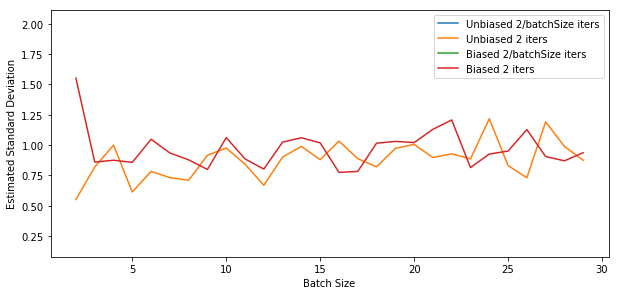

In [115]:
runVarianceExperiment(fixupIters=2, maxBatchSize=30)

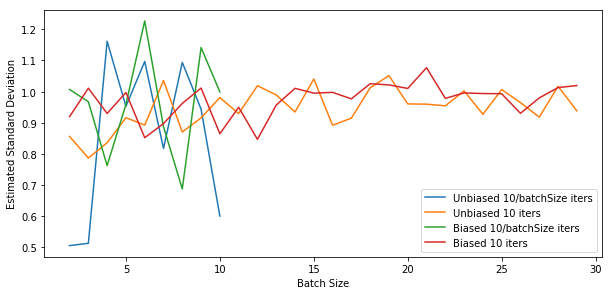

In [116]:
runVarianceExperiment(fixupIters=10, maxBatchSize=30)

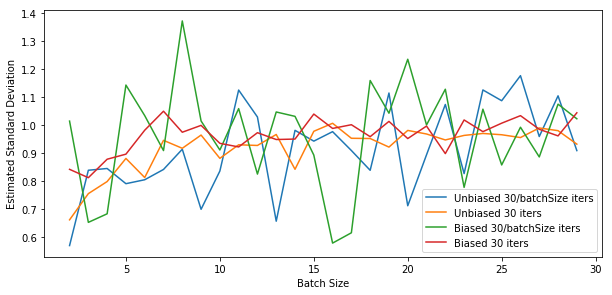

In [119]:
runVarianceExperiment(fixupIters=30, maxBatchSize=30)

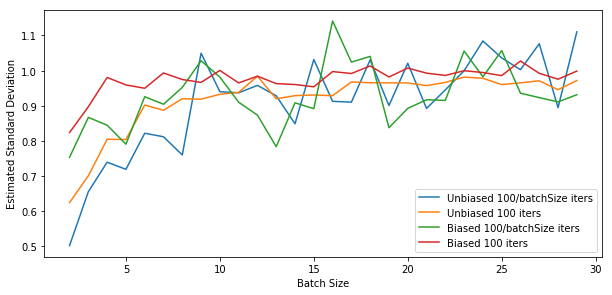

In [120]:
runVarianceExperiment(fixupIters=100, maxBatchSize=30)

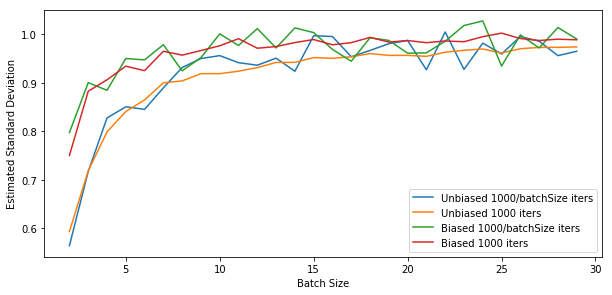

In [121]:
runVarianceExperiment(fixupIters=1000, maxBatchSize=30)

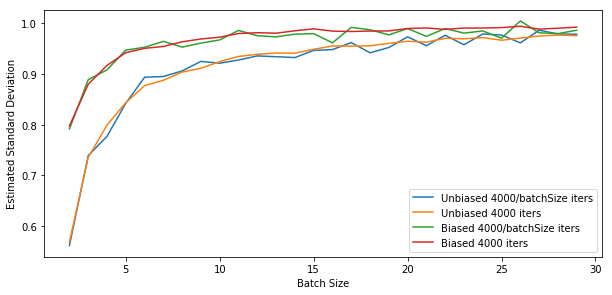

In [123]:
runVarianceExperiment(fixupIters=4000, maxBatchSize=30)

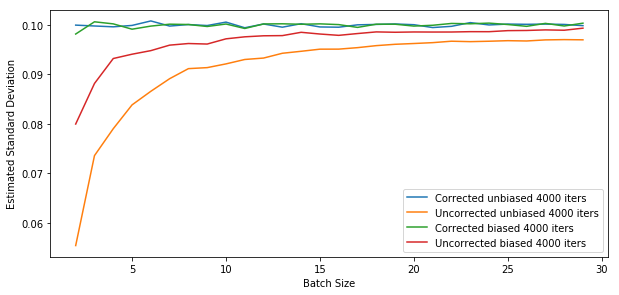

In [190]:
runVarianceExperimentFixed(fixupIters=4000, maxBatchSize=30, variance=0.1, mean=-21.0)

In [162]:
# So we need about 1000-4000 before we can get reliable estimates. Unbiased and biased are both off for very small batch sizes.
# We can compute those correction factors:

_, unbiased, _, biased = runVarianceExperiment(fixupIters=20000, maxBatchSize=50, returnResults=True)
unbiasedCorrectionFactors = [1.0/x[2] for x in unbiased]
biasedCorrectionFactors = [1.0/x[2] for x in biased]


In [181]:
res = np.zeros([len(biasedCorrectionFactors), 2])
res[:,0] = np.arange(2,len(biasedCorrectionFactors)+2)
res[:,1] = np.array(biasedCorrectionFactors)
for i in range(len(biasedCorrectionFactors)):
    print(str(unbiasedCorrectionFactors[i]) + ",")


1.7799566119279853,
1.3835213244425826,
1.2482936164260439,
1.1859764910067494,
1.1527180214702217,
1.1287027492576438,
1.1091396705334995,
1.094898271770653,
1.082931039668834,
1.0764941353095347,
1.0679086846394927,
1.0603455707489202,
1.05773759417192,
1.0523181089653626,
1.0504050835019656,
1.0479348603532501,
1.0457618548486025,
1.0411766180695343,
1.0405091278274154,
1.0366884234345293,
1.0355762814914031,
1.0350525212831747,
1.0308395043432088,
1.031441310165047,
1.0311827188367804,
1.0286422630353453,
1.0281446453485925,
1.0275181081122298,
1.026005419773121,
1.0253151870099,
1.023740815618702,
1.023379813344318,
1.022077366672312,
1.018895448231097,
1.0217381944230024,
1.021486621693096,
1.021514858353326,
1.0191393076308053,
1.018925460157928,
1.020164793074668,
1.0188441535877615,
1.0172892685458716,
1.0184334258938206,
1.0150757715235856,
1.0175068110884677,
1.0163974291176878,
1.0156363118390117,
1.0167828524752347,


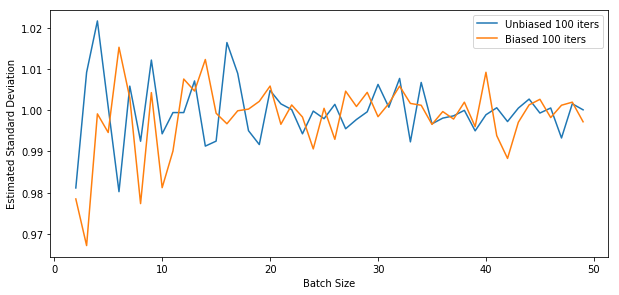

In [160]:

vals1, vals2, vals3, vals4 = runVarianceExperiment(fixupIters=1000, maxBatchSize=50, returnResults=True)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.plot([x[0] for x in vals2], [x[2]*unbiasedCorrectionFactors[i] for i, x in enumerate(vals2)], label="Unbiased " + str(fixupIters) + " iters")
ax1.plot([x[0] for x in vals4], [x[2]*biasedCorrectionFactors[i] for i, x in enumerate(vals4)], label="Biased " + str(fixupIters) + " iters")
ax1.set_ylabel('Estimated Standard Deviation')
ax1.set_xlabel('Batch Size')
ax1.legend()

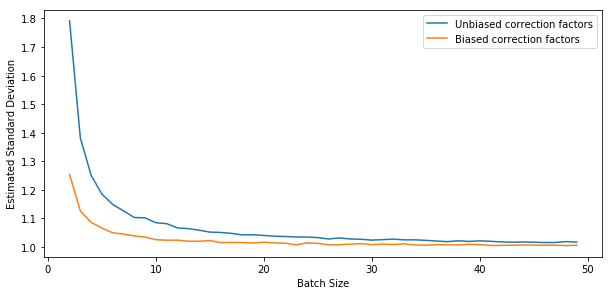

In [161]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.plot([x for x in range(2, len(unbiasedCorrectionFactors)+2)], [y for y in unbiasedCorrectionFactors], label="Unbiased correction factors")
ax1.plot([x for x in range(2, len(biasedCorrectionFactors)+2)], [y for y in biasedCorrectionFactors], label="Biased correction factors")
ax1.set_ylabel('Estimated Standard Deviation')
ax1.set_xlabel('Batch Size')
ax1.legend()

[1.26768811 1.16369042 1.11783821 1.09202125 1.07546241 1.06393882
 1.0554569  1.04895277]


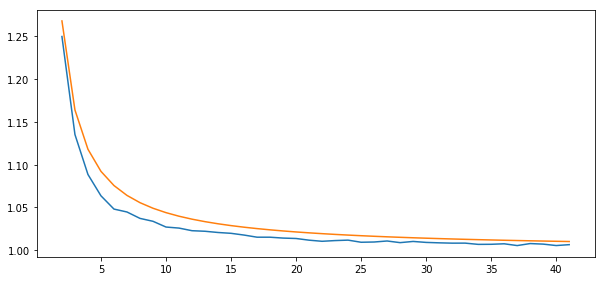

In [179]:
biasedCorrectionFactorsLess = biasedCorrectionFactors[:40]
biasedX = [x for x in range(2, len(biasedCorrectionFactorsLess)+2)]
biasedY = biasedCorrectionFactorsLess
fittedPoly = np.polyfit(biasedX, np.log(biasedY), deg=10)
p = np.poly1d(fittedPoly)
fig = plt.figure(figsize=(10,10))

fitEq = lambda x: (0.99967*x)/(-0.4228455 + x)
print(fitEq(np.arange(2, 10)))

ax1 = fig.add_subplot(211)
ax1.plot(biasedX, biasedY, label="Biased correction factors")
ax1.plot(biasedX, fitEq(np.array(biasedX)), label="Fitted correction factors")

Text(0.5,0,'Batch Size')

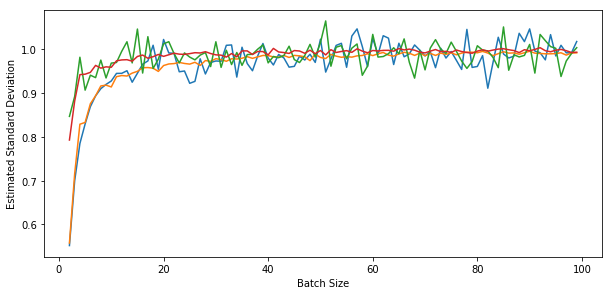

In [93]:

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
ax1.plot([x[0] for x in vals1], [x[1] for x in vals1])
ax1.plot([x[0] for x in vals2], [x[1] for x in vals2])
ax1.plot([x[0] for x in vals3], [x[1] for x in vals3])
ax1.plot([x[0] for x in vals4], [x[1] for x in vals4])
ax1.set_ylabel('Estimated Standard Deviation')
ax1.set_xlabel('Batch Size')

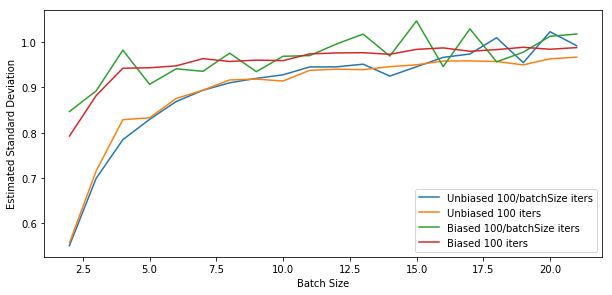

In [94]:

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(211)
firstFew = 20
ax1.plot([x[0] for x in vals1[:firstFew]], [x[1] for x in vals1[:firstFew]], label="Unbiased " + str(fixupIters) + "/batchSize iters")
ax1.plot([x[0] for x in vals2[:firstFew]], [x[1] for x in vals2[:firstFew]], label="Unbiased " + str(fixupIters) + " iters")
ax1.plot([x[0] for x in vals3[:firstFew]], [x[1] for x in vals3[:firstFew]], label="Biased " + str(fixupIters)+ "/batchSize iters")
ax1.plot([x[0] for x in vals4[:firstFew]], [x[1] for x in vals4[:firstFew]], label="Biased " + str(fixupIters) + " iters")
ax1.set_ylabel('Estimated Standard Deviation')
ax1.set_xlabel('Batch Size')
ax1.legend()

In [515]:
def variance(a, **kwargs):
    return (a.pow(2)).mean(**kwargs) + a.mean(**kwargs).pow(2)

def variance2(a, **kwargs):
    return (a-a.mean(keepdim=True, **kwargs)).pow(2).mean(**kwargs)




print(variance2(torch.normal(0, 1, [1000]), axis=0))

a = torch.normal(0, 1, [4, 5])
f = a.mean(axis=0, keepdim=True)
f.pow(2).mean()
print(a[:,0], a[:,0].mean())
print(f.shape, f)
print(a, a - a.mean(keepdim=True, axis=0), (a-a.mean(keepdim=True, axis=0)).pow(2).mean(keepdim=True, axis=0), variance(a, keepdim=True, axis=0), "hhh", variance2(a, axis=0))

variance(a, axis=0).mean(), variance2(a, axis=0).mean()

tensor(0.9983)
tensor([ 0.3440,  1.4775, -0.2170,  1.1752]) tensor(0.6949)
torch.Size([1, 5]) tensor([[ 0.6949,  0.4711,  0.8089, -0.7772,  0.1219]])
tensor([[ 0.3440,  0.7092,  0.6088, -0.6691,  1.2032],
        [ 1.4775, -0.1609,  0.7756, -0.9842, -0.8903],
        [-0.2170,  0.1969,  1.0542, -1.1420,  0.1661],
        [ 1.1752,  1.1392,  0.7972, -0.3135,  0.0085]]) tensor([[-0.3509,  0.2381, -0.2002,  0.1081,  1.0813],
        [ 0.7826, -0.6320, -0.0333, -0.2070, -1.0122],
        [-0.9119, -0.2742,  0.2452, -0.3648,  0.0442],
        [ 0.4803,  0.6681, -0.0118,  0.4637, -0.1133]]) tensor([[0.4495, 0.2444, 0.0254, 0.1007, 0.5522]]) tensor([[1.4154, 0.6883, 1.3341, 1.3088, 0.5819]]) hhh tensor([0.4495, 0.2444, 0.0254, 0.1007, 0.5522])


(tensor(1.0657), tensor(0.2744))

In [280]:
def testFeedforward(debug=False):
    def debugPrint(*args, **kwargs):
        if debug: print(*args, **kwargs)
    batchSize = 3
    inputSize = 2
    hiddenSize = 4
    x = torch.normal(0, 1, [batchSize, inputSize])
    debugPrint(x)
    layer = FeedforwardLayer(inputSize, hiddenSize)
    for p in layer.parameters():
        debugPrint(p)
    y = layer(x)
    debugPrint(y)
    weights = layer.weights
    bias = layer.bias
    firstOutputBatch1 = x[0]@layer.weights[:,0]+layer.bias[0]
    secondOutputBatch1 = x[0]@layer.weights[:,1]+layer.bias[1]
    firstOutputBatch2 = x[1]@layer.weights[:,0]+layer.bias[0]
    secondOutputBatch2 = x[1]@layer.weights[:,1]+layer.bias[1]
    debugPrint(x[0],"*",layer.weights[:,0],"+",layer.bias[0], "=", firstOutputBatch1) 
    debugPrint(x[0],"*",layer.weights[:,1],"+",layer.bias[1], "=", secondOutputBatch1)
    debugPrint(x[1],"*",layer.weights[:,0],"+",layer.bias[0], "=", firstOutputBatch2) 
    debugPrint(x[1],"*",layer.weights[:,1],"+",layer.bias[1], "=", secondOutputBatch2) 
    approx_equals(firstOutputBatch1, y[0,0])
    approx_equals(secondOutputBatch1, y[0,1])
    approx_equals(firstOutputBatch2, y[1,0])
    approx_equals(secondOutputBatch2, y[1,1])
    
testFeedforward()